<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_4/Week_4_Lecture_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3: Feedforward Neural Networks and Backpropagation Part 1  <sup><mark style="background-color:gold">Code</mark> </sup>

In [31]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"8sjbwfHdqW8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [32]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_4/DL4CV_Week04_Part02.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

**Imports**

In [33]:
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

**Helper Functions for Plotting**

In [34]:
def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

## Gradient Descent Algorithm

Since the goal of most learning algorithms is **minimizing the risk (also known as the cost or loss) function**, optimization is often the core of most machine learning techniques! The gradient descent algorithm, along with its variations such as stochastic gradient descent, is one of the most powerful and popular optimization methods used for deep learning.

### Gradient vector 

Given the following function:

\begin{equation}
z = h(x, y) = \sin(x^2 + y^2)
\end{equation}

find the gradient vector:

\begin{equation}
  \begin{bmatrix}
  \dfrac{\partial z}{\partial x} \\ \\ \dfrac{\partial z}{\partial y}
  \end{bmatrix}
\end{equation}


*Hint: Use the chain rule!*

**Chain rule**: For a composite function $F(x) = g(h(x)) \equiv (g \circ h)(x)$:

\begin{equation}
F'(x) = g'(h(x)) \cdot h'(x)
\end{equation}

or differently denoted:

\begin{equation}
\frac{dF}{dx} = \frac{dg}{dh} ~ \frac{dh}{dx}
\end{equation}

---
#### Solution:
We can rewrite the function as a composite function:

\begin{equation}
z = f\left( g(x,y) \right), ~~ f(u) = \sin(u), ~~ g(x, y) = x^2 + y^2
\end{equation}

Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

\begin{align}
\dfrac{\partial z}{\partial x} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial x} = \cos(g(x,y)) ~ (2x) = \cos(x^2 + y^2) \cdot 2x \\ \\
\dfrac{\partial z}{\partial y} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial y} = \cos(g(x,y)) ~ (2y) = \cos(x^2 + y^2) \cdot 2y
\end{align}

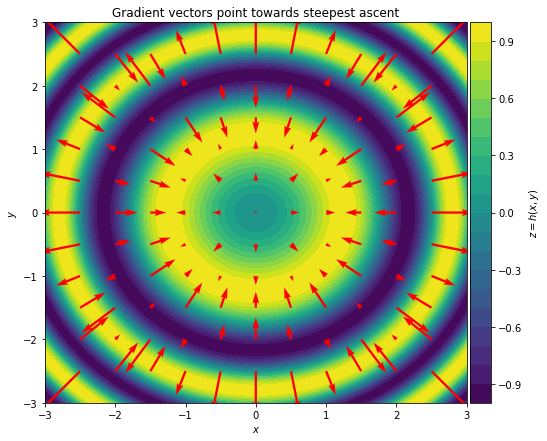

In [35]:
def fun_z(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    z: (float, np.ndarray)
      sin(x^2 + y^2)
  """
  z = np.sin(x**2 + y**2)
  return z


def fun_dz(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2)
  """

  dz_dx = 2 * x * np.cos(x**2 + y**2)
  dz_dy = 2 * y * np.cos(x**2 + y**2)
  return (dz_dx, dz_dy)

ex1_plot(fun_z, fun_dz)

We can see from the plot that for any given $x_0$ and $y_0$, the gradient vector $\left[ \dfrac{\partial z}{\partial x}, \dfrac{\partial z}{\partial y}\right]^{\top}_{(x_0, y_0)}$ points in the direction of $x$ and $y$ for which $z$ increases the most. It is important to note that gradient vectors only see their local values, not the whole landscape! Also, length (size) of each vector, which indicates the steepness of the function, can be very small near local plateaus (i.e. minima or maxima).

Thus, we can simply use the aforementioned formula to find the local minima. 

In 1847, Augustin-Louis Cauchy used **negative of gradients**  to develop the Gradient Descent algorithm as an **iterative** method to **minimize** a **continuous** and (ideally) **differentiable function** of **many variables**.

### Gradient Descent Algorithm

Let $f(\mathbf{w}): \mathbb{R}^d \rightarrow \mathbb{R}$ be a differentiable function. Gradient Descent is an iterative algorithm for minimizing the function $f$, starting with an initial value for variables $\mathbf{w}$, taking steps of size $\eta$ (learning rate) in the direction of the negative gradient at the current point to update the variables $\mathbf{w}$.

\begin{equation}
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)
\end{equation}

where $\eta > 0$ and $\nabla f (\mathbf{w})= \left( \frac{\partial f(\mathbf{w})}{\partial w_1}, ..., \frac{\partial f(\mathbf{w})}{\partial w_d} \right)$. Since negative gradients always point locally in the direction of steepest descent, the algorithm makes small steps at each point **towards** the minimum.
  
<br/>

**Vanilla Algorithm**

---
> **Inputs:** initial guess $\mathbf{w}^{(0)}$, step size $\eta > 0$, number of steps $T$.

> **For** $t = 0, 1, 2, \dots , T-1$ **do** \
$\qquad$ $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)$\
**end**

> **Return:** $\mathbf{w}^{(t+1)}$

---

<br/>

Hence, all we need is to calculate the gradient of the loss function with respect to the learnable parameters (i.e., weights):

\begin{equation}
\dfrac{\partial Loss}{\partial \mathbf{w}} = \left[ \dfrac{\partial Loss}{\partial w_1}, \dfrac{\partial Loss}{\partial w_2} , \dots, \dfrac{\partial Loss}{\partial w_d} \right]^{\top}
\end{equation}

##  PyTorch AutoGrad


Deep learning frameworks such as PyTorch, JAX, and TensorFlow come with a very efficient and sophisticated set of algorithms, commonly known as Automatic Differentiation. AutoGrad is PyTorch's automatic differentiation engine. 

### Forward Propagation



Everything starts with the forward propagation (pass). PyTorch tracks all the instructions, as we declare the variables and operations, and it builds the graph when we call the `.backward()` pass. PyTorch rebuilds the graph every time we iterate or change it (or simply put, PyTorch uses a dynamic graph).

For gradient descent, it is only required to have the gradients of cost function with respect to the variables we wish to learn. These variables are often called "learnable / trainable parameters" or simply "parameters" in PyTorch. In neural nets, weights and biases are often the learnable parameters.

#### Buiding a Computational Graph

In PyTorch, to indicate that a certain tensor contains learnable parameters, we can set the optional argument `requires_grad` to `True`. PyTorch will then track every operation using this tensor while configuring the computational graph. For this code snippet, use the provided tensors to build the following graph, which implements a single neuron with scalar input and output.

<br>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/simple_graph.png" alt="Simple nn graph" width="600"/></center>

In [36]:
class SimpleGraph:
  """
  Implementing Simple Computational Graph
  """

  def __init__(self, w, b):
    """
    Initializing the SimpleGraph

    Args:
      w: float
        Initial value for weight
      b: float
        Initial value for bias

    Returns:
      Nothing
    """
    assert isinstance(w, float)
    assert isinstance(b, float)
    self.w = torch.tensor([w], requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        1D tensor of features

    Returns:
      prediction: torch.Tensor
        Model predictions
    """
    assert isinstance(x, torch.Tensor)
    
    prediction = torch.tanh(x * self.w + self.b)
    return prediction


def sq_loss(y_true, y_prediction):
  """
  L2 loss function

  Args:
    y_true: torch.Tensor
      1D tensor of target labels
    y_prediction: torch.Tensor
      1D tensor of predictions

  Returns:
    loss: torch.Tensor
      L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  
  loss = (y_true - y_prediction)**2
  return loss



feature = torch.tensor([1])  # Input tensor
target = torch.tensor([7])  # Target tensor
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

initial weight = -0.5, 
initial bias = 0.5
for x=1 and y=7, prediction=0.0, and L2 Loss = 49.0


It is important to appreciate the fact that PyTorch can follow our operations as we arbitrarily go through classes and functions.

### Backward Propagation

Here is where all the magic lies. In PyTorch, `Tensor` and `Function` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each variable has a `grad_fn` attribute that references a function that has created the Tensor (except for Tensors created by the user - these have `None` as `grad_fn`).  The example below shows that the tensor `c = a + b` is created by the `Add` operation and the gradient function is the object `<AddBackward...>`. Replace `+` with other single operations (e.g., `c = a * b` or `c = torch.sin(a)`) and examine the results.

In [37]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a + b
print(f'Gradient function = {c.grad_fn}')

Gradient function = <AddBackward0 object at 0x7fec3fb76490>


For more complex functions, printing the `grad_fn` would only show the last operation, even though the object tracks all the operations up to that point:

In [38]:
print(f'Gradient function for prediction = {prediction.grad_fn}')
print(f'Gradient function for loss = {square_loss.grad_fn}')

Gradient function for prediction = <TanhBackward0 object at 0x7fec3fb761d0>
Gradient function for loss = <PowBackward0 object at 0x7fec3fb766d0>


Now let's kick off the backward pass to calculate the gradients by calling `.backward()` on the tensor we wish to initiate the backpropagation from. Often, `.backward()` is called on the loss, which is the last node on the graph. Before doing that, let's calculate the loss gradients by hand:

$$\frac{\partial{loss}}{\partial{w}} = - 2 x (y_t - y_p)(1 - y_p^2)$$

$$\frac{\partial{loss}}{\partial{b}} = - 2 (y_t - y_p)(1 - y_p^2)$$

Where $y_t$ is the target (true label), and $y_p$ is the prediction (model output). We can then compare it to PyTorch gradients, which can be obtained by calling `.grad` on the relevant tensors.

**Important Notes:**
* Learnable parameters (i.e. `requires_grad` tensors) are "contagious". Let's look at a simple example: `Y = W @ X`, where `X` is the feature tensors and `W` is the weight tensor (learnable parameters, `requires_grad`), the newly generated output tensor `Y` will be also `requires_grad`. So any operation that is applied to `Y` will be part of the computational graph. Therefore, if we need to plot or store a tensor that is `requires_grad`, we must first `.detach()` it from the graph by calling the `.detach()` method on that tensor.

* `.backward()` accumulates gradients in the leaf nodes (i.e., the input nodes to the node of interest). We can call `.zero_grad()` on the loss or optimizer to zero out all `.grad` attributes (see [autograd.backward](https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward) for more information).

* Recall that in python we can access variables and associated methods with `.method_name`. You can use the command `dir(my_object)` to observe all variables and associated methods to your object, e.g., `dir(simple_graph.w)`.

In [39]:
# Analytical gradients (Remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # First we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad  # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad  # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([True])
tensor([True])


## References and more:

* [A gentle introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

* [Automatic Differentiation package - torch.autograd](https://pytorch.org/docs/stable/autograd.html)

* [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

* [Automatic Differentiation with torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

**Acknowledgements**

Code adopted from the Deep Learning Summer School offered by Neuromatch Academy

https://deeplearning.neuromatch.io/tutorials/intro.html